# Plot data of the main experiments

Include all libraries

In [1]:
import lzma
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import figure_options
from matplotlib.lines import Line2D  # Import Line2D for custom legend handle
from figure_options import plt, sns, rc_parameters
from scipy.stats import bootstrap
from scipy.special import rel_entr
from environment import run_experiment, RunParameters, RunStatistics
from baifg.model.feedback_graph import FeedbackGraph
from baifg.model.reward_model import GaussianRewardModel, RewardType
from baifg.algorithms.eps_greedy import EpsilonGreedy, EpsilonGreedyParameters
from baifg.algorithms.ucb import UCB
from baifg.algorithms.exp3g import Exp3G, Exp3GParameters
from baifg.algorithms.tas_fg import TaSFG, TaSFGParameters
from baifg.algorithms.base.graph_estimator import GraphEstimator
from baifg.algorithms.base.base_algorithm import BaseAlg
from baifg.utils.graphs import make_loopless_clique, make_loopystar_graph
from baifg.utils.characteristic_time import compute_characteristic_time
from itertools import product
from typing import List, NamedTuple
from tqdm import tqdm

colors = ['#00bfc4', 'mediumorchid', '#7f7f7f','#f8766d', '#3B3B3B','#0096FF','#a3a500']


Load the data. The data is stored as a python dictionary using pickle, and compressed using LZMA. Make sure to adjust the `path` variable

In [2]:
path = './data/full_data_241005.lzma'

with lzma.open(path, 'rb') as f:
    data = pickle.load(f)

df = data['df']

map_name = {
    '$\\epsilon$-greedy': r"$\epsilon$-greedy",
    '$\\epsilon$-greedy IG': r"$\epsilon$-greedy IG",
    'TaS-FG': 'TaS-FG',
    'EXP3.G': 'EXP3.G',
    'UCB':'UCB',
}

palette = {
    r"$\epsilon$-greedy": sns.color_palette("Set2")[0],
    r"$\epsilon$-greedy FG": sns.color_palette("Set2")[1],
    'EXP3.G': sns.color_palette("Set2")[2],
    'TaS-FG': sns.color_palette("Set2")[3],
    'UCB-FG-E': sns.color_palette("Set2")[4],
    'UCB-FG-V': sns.color_palette("Set2")[5],
    'TaS-FG Heur.': sns.color_palette("Set2")[6],
    'Lower bound': 'black'  # Change to 'darkred' if desired
}


Compute lower bounds and characteristic times

In [3]:
# Change names
df['env'] = df['env'].apply(lambda x: x if x != 'Loopystar (hard)' else 'Loopystar (alt.)')
df['algorithm'] = df['algorithm'].apply(lambda x: str(x))

# Compute lower bound for each environment configuration
df['lb'] = df['characteristic_time'] * (rel_entr(1-df['delta'], df['delta']) + rel_entr(df['delta'], 1-df['delta']))
taSFG_rows = df[df['algorithm'] == 'TaS-FG'].copy()
lb_df = taSFG_rows.copy()
lb_df['algorithm'] = 'Lower bound'
lb_df['stopping_time'] = lb_df['lb']
lb_df['identified_optimal_arm'] = True
df_with_lower_bound = pd.concat([df, lb_df], ignore_index=True)
df_with_lower_bound['delta'] = np.log(1/df_with_lower_bound['delta'])

# Compute normalized stopping time
df_with_lower_bound['normalized_stopping_time'] = df_with_lower_bound['stopping_time'] / df_with_lower_bound['lb']

In [4]:
df

,env,K,seed,algorithm,delta,stopping_time,identified_optimal_arm,characteristic_time,lb
0,Loopless clique,5,0,$\epsilon$-greedy,0.367879,374,True,128.014772,18.311269
1,Loopless clique,5,0,$\epsilon$-greedy FG,0.367879,374,True,128.014772,18.311269
2,Loopless clique,5,0,EXP3.G,0.367879,5,False,128.014772,18.311269
3,Loopless clique,5,0,TaS-FG,0.367879,600,True,128.014772,18.311269
4,Loopless clique,5,0,TaS-FG Heur.,0.367879,1129,True,128.014772,18.311269
...,...,...,...,...,...,...,...,...,...
50395,Loopystar (alt.),15,0,EXP3.G,0.000912,27926,True,252.855718,1766.531721
50396,Loopystar (alt.),15,0,TaS-FG,0.000912,2824,True,252.855718,1766.531721
50397,Loopystar (alt.),15,0,TaS-FG Heur.,0.000912,19356,True,252.855718,1766.531721
50398,Loopystar (alt.),15,0,UCB-FG-V,0.000912,15128,True,252.855718,1766.531721


In [30]:
# Define the grouping columns
group_cols = ['env', 'K', 'algorithm', 'delta']

# Group the DataFrame
grouped = df_with_lower_bound.groupby(group_cols)

# Define a function to compute mean and confidence intervals
def compute_stats(group, n_boot=1000, ci=95):
    data = group['identified_optimal_arm'].astype(float).values  # Convert bool to int (True=1, False=0)
    mean = data.mean()
    res = bootstrap((data,), np.mean)
    return pd.Series({
        'mean_identified_optimal_arm': mean,
        'ci_lower': res.confidence_interval.low,
        'ci_upper': res.confidence_interval.high
    })

# Apply the function to each group
df_risk = grouped.apply(compute_stats).reset_index()


c:\Users\arusso2\github\Best-Arm-Identification-with-Feedback-Graph\.venv\Lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_17440\1387171992.py:11: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((data,), np.mean)
c:\Users\arusso2\github\Best-Arm-Identification-with-Feedback-Graph\.venv\Lib\site-packages\scipy\stats\_resampling.py:149: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_17440\1387171992.py:11: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = bootstrap((data,), np.me

In [32]:
df_risk_filt = df_risk[(df_risk['delta']==7.0) & (df_risk['algorithm'] == 'UCB-FG')]
df_risk_filt

,env,K,algorithm,delta,mean_identified_optimal_arm,ci_lower,ci_upper
41,Loopless clique,5,UCB-FG,7.0,0.98,0.93000,1.00
83,Loopless clique,10,UCB-FG,7.0,0.97,0.92000,0.99
125,Loopless clique,15,UCB-FG,7.0,0.93,0.86000,0.97
167,Loopystar,5,UCB-FG,7.0,0.99,0.94000,1.00
209,Loopystar,10,UCB-FG,7.0,0.93,0.87000,0.97
251,Loopystar,15,UCB-FG,7.0,0.89,0.81272,0.94
293,Loopystar (alt.),5,UCB-FG,7.0,1.00,NaN,NaN
335,Loopystar (alt.),10,UCB-FG,7.0,0.99,0.94000,1.00
377,Loopystar (alt.),15,UCB-FG,7.0,0.97,0.92000,0.99
419,Ring,5,UCB-FG,7.0,0.99,0.95000,1.00


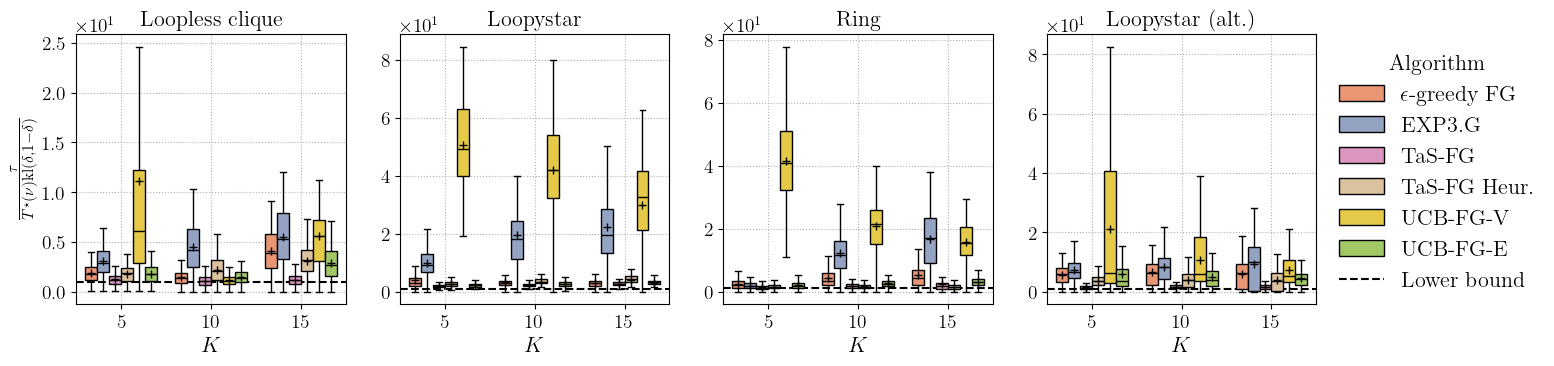

In [4]:
envs = df_with_lower_bound['env'].unique()
num_algo = len(df_with_lower_bound['algorithm'].unique())
# Adding hatch patterns to each algorithm
hatches = {
     r"$\epsilon$-greedy": '/',
    r"$\epsilon$-greedy IG": '\\',
    'EXP3.G': '|',
    'TaS-FG': '-',
    'UCB': '+',
    'Lower bound': 'x'
}
hatches = ['-', '+', '*', r'.', '+', 'o']#, 'o', 'O', '.', '*']

fig, ax = plt.subplots(1,len(envs), figsize=(4 * len(envs),3.5))

for idx, env_name in enumerate(envs):

    # Filter the DataFrame for the selected environment
    
    df_env = df_with_lower_bound[(df_with_lower_bound['env'] == env_name) & (df_with_lower_bound['delta']==7.0)]
    df_env = df_env[df_env['algorithm'] != '$\epsilon$-greedy']
    # df_env = df_env[df_env['algorithm'] != '$\epsilon$-greedy FG']
    df_env = df_env[df_env['algorithm'] != 'Lower bound']
    # Create a boxplot
    # sns.boxplot(
    #     x='K',
    #     y='stopping_time',
    #     hue='algorithm',
    #     data=df_env,
    #     palette='Set2',
    #     ax=ax[idx]
    # )
    bar = sns.boxplot(
        x='K',
        y='normalized_stopping_time',
        hue='algorithm',
        data=df_env,
        showfliers=False,
        palette=palette,
        showmeans=True,
        meanprops={'marker':'+','markerfacecolor':'black','markeredgecolor':'black','markersize':'6'},
        #errorbar=('ci', 95),           # Confidence interval
        #capsize=0.1,      # Width of the error bar caps
        #estimator='mean',  # Function to estimate central tendency
        ax=ax[idx],
        legend=True if idx == len(envs)-1 else False
    )
    ax[idx].axhline(y=1, linestyle='--', color='k', zorder=0)
    ax[idx].set_ylabel(r'')
    ax[idx].set_xlabel('$K$')
    
    ax[idx].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[idx].set_title(env_name)
    # Adjust legend
    if idx == 0:
        ax[idx].set_ylabel(r' $\frac{\tau}{T^\star(\nu){\rm kl}(\delta,1-\delta)}$')
    if idx == len(envs)-1:
        #ax[idx].legend(title='Algorithm', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

        # Get existing handles and labels from the boxplot
        handles, labels = ax[idx].get_legend_handles_labels()
        
        # Create a custom handle for the horizontal line
        line_handle = Line2D([0], [0], color='k', linestyle='--', label='Lower bound')
        
        # Append the custom handle to the existing handles and labels
        handles.append(line_handle)
        labels.append('Lower bound')
        
        # Update the legend with the new handles and labels
        ax[idx].legend(handles=handles, title='Algorithm', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)


    ax[idx].grid(linestyle = ":")

    
plt.savefig('figures/results/sample_complexity_summary.pdf', bbox_inches='tight')

C:\Users\arusso2\AppData\Local\Temp\ipykernel_17440\3059852811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_17440\3059852811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
C:\Users\arusso2\AppData\Local\Temp\ipykernel_17440\3059852811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

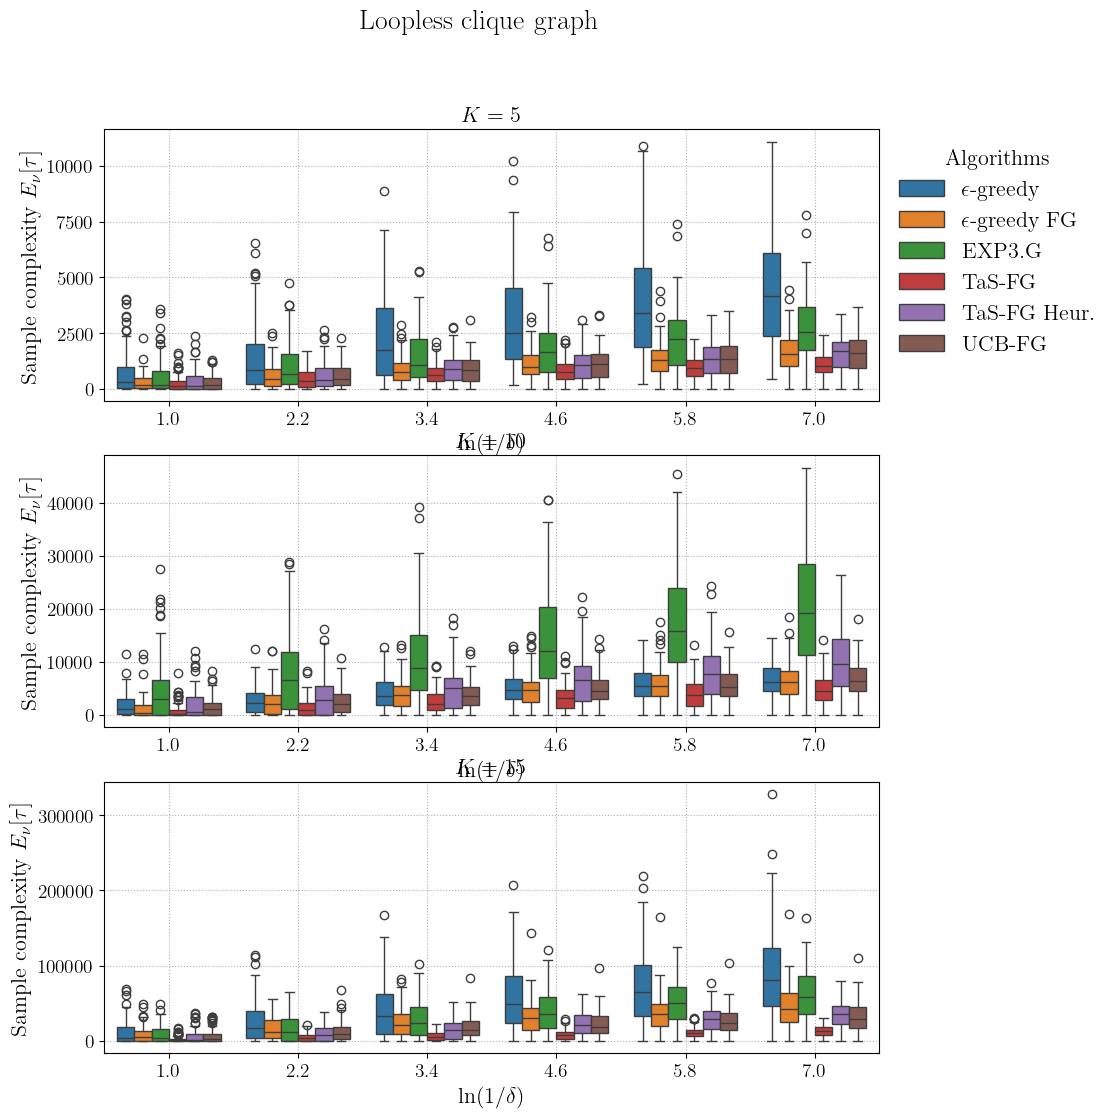

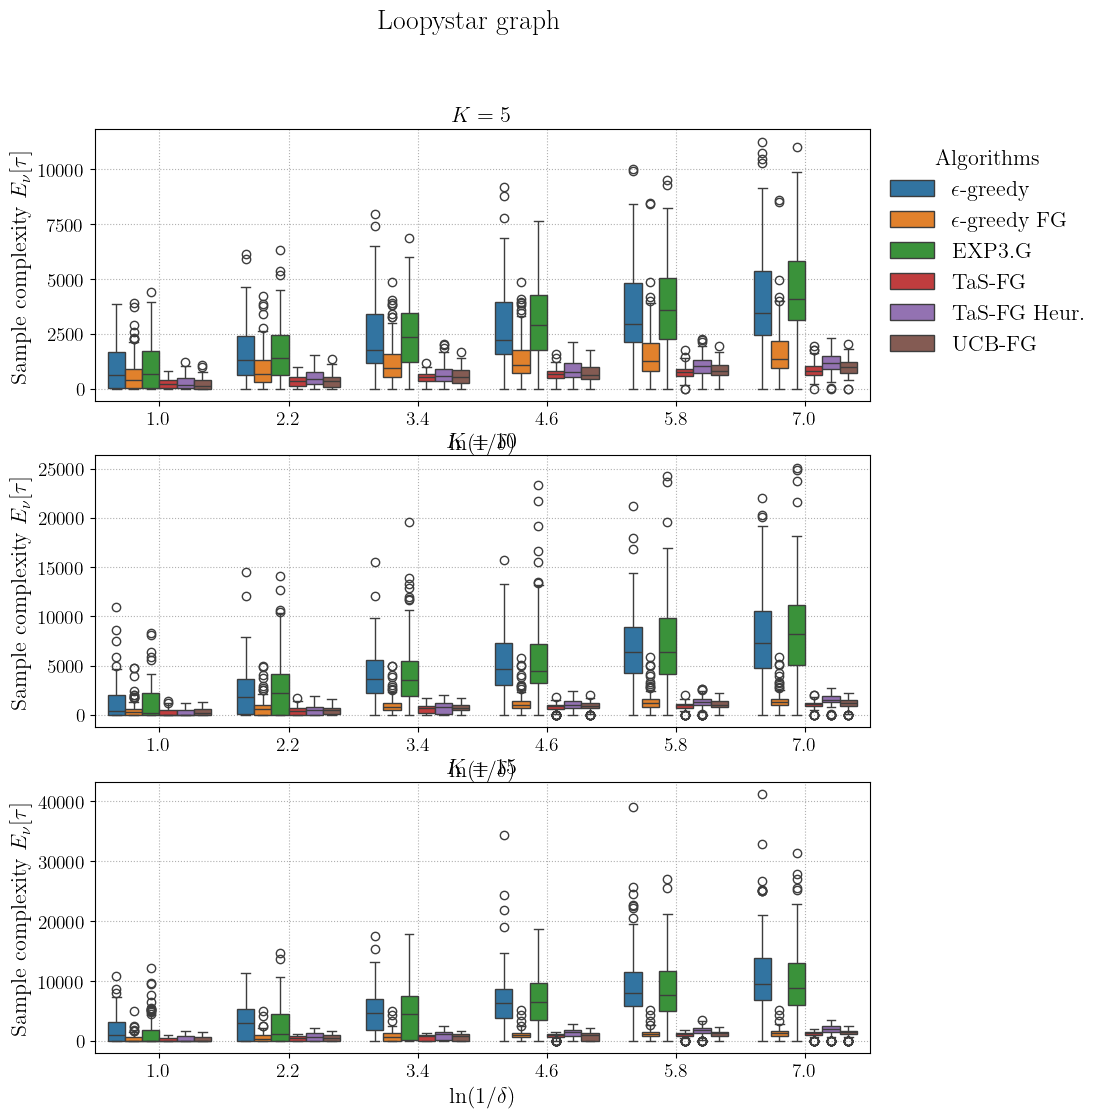

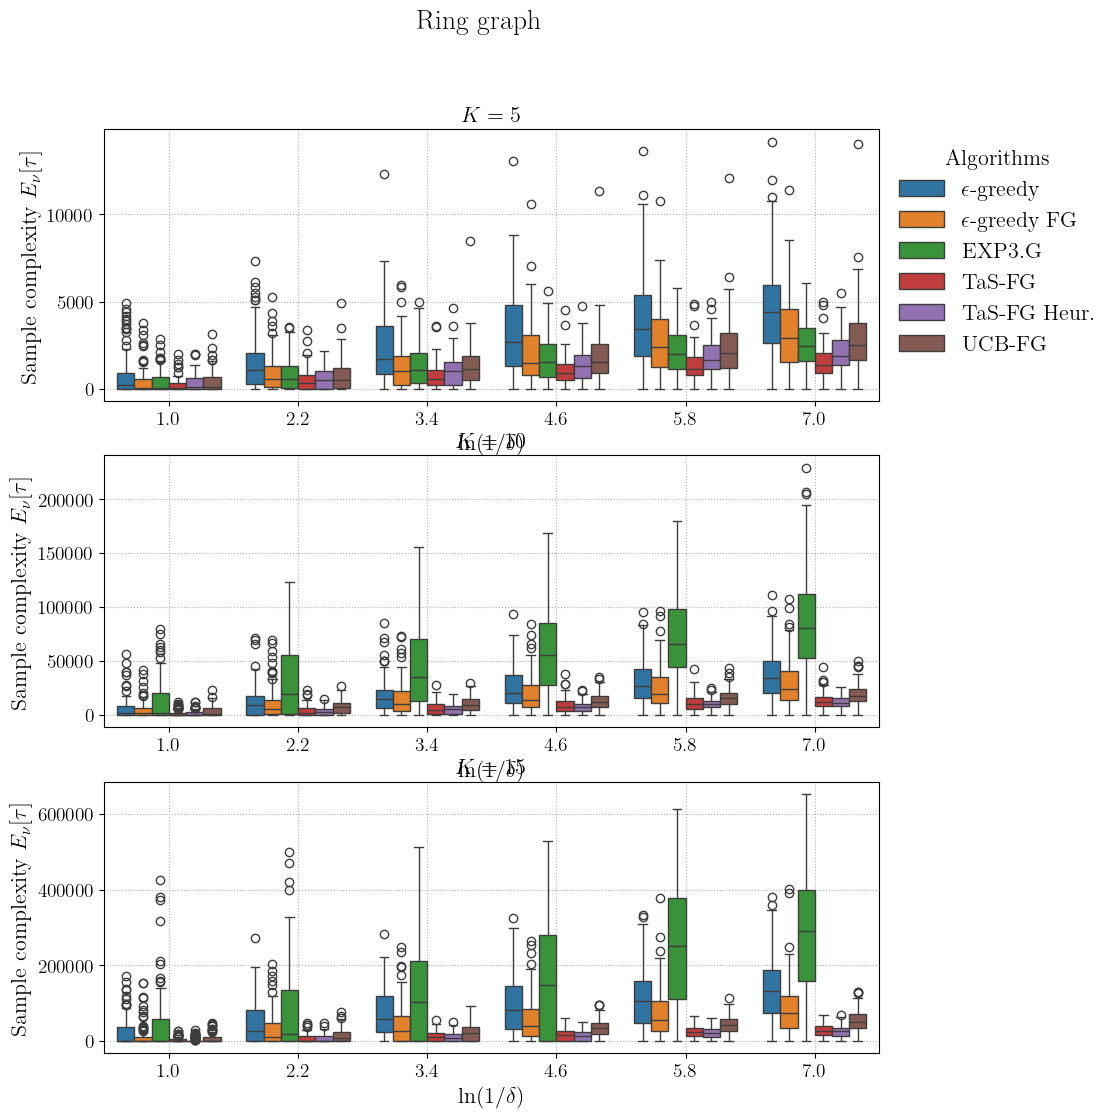

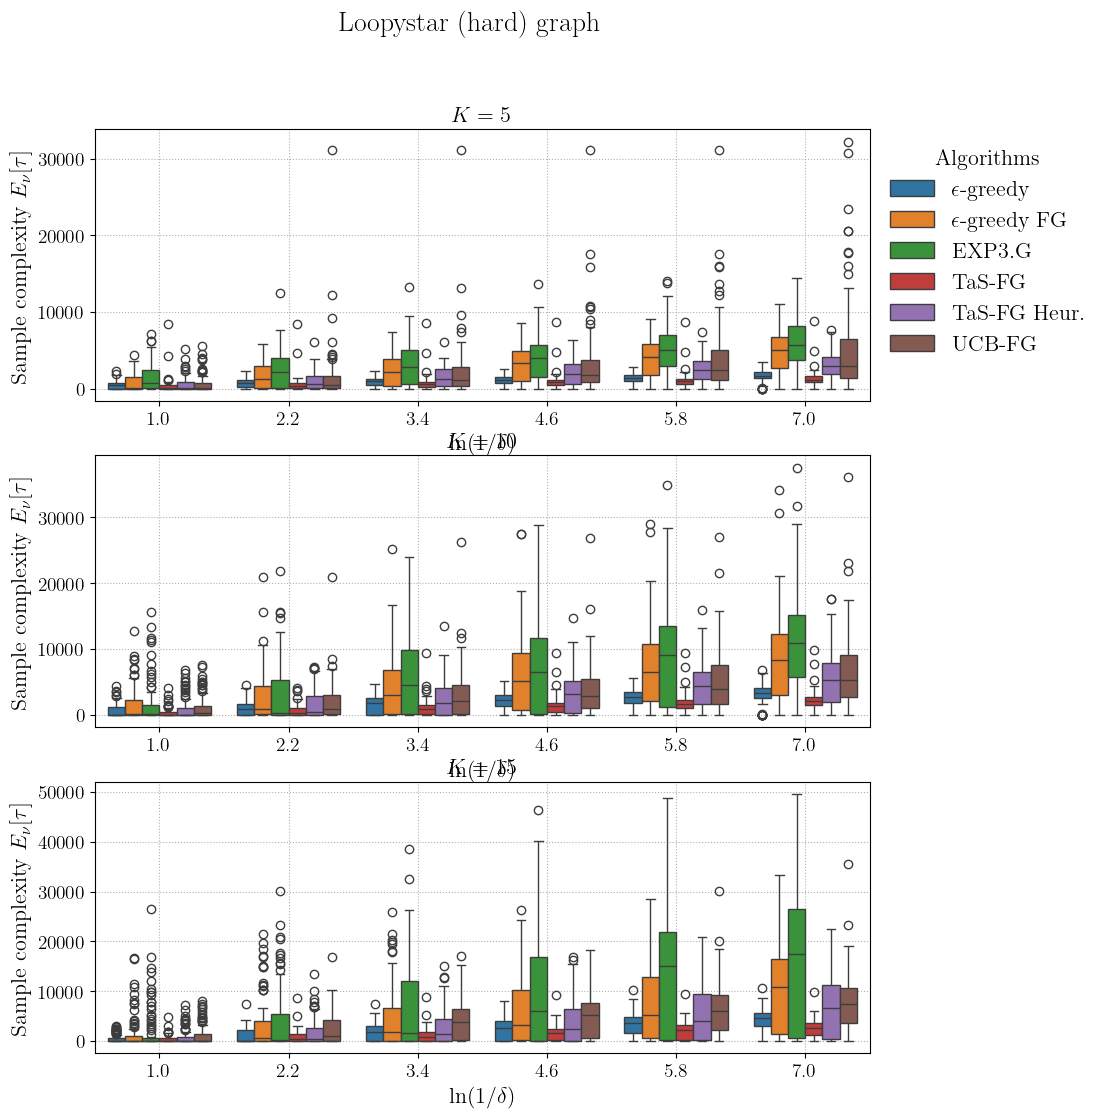

In [6]:
Kvalues = df['K'].unique()
envs = df['env'].unique()

for envname  in envs:
    fig, ax = plt.subplots(len(Kvalues), 1, figsize=(10,12))
    for idx, K in enumerate(Kvalues):
        # Filter the DataFrame for a given environment, e.g., "Loopless clique"
        filtered_df = df[(df['env'] == envname) & (df['K'] == K)]
        filtered_df['delta'] = np.log(1/filtered_df['delta']).round(2)
        sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df, ax=ax[idx], legend=True if idx ==0 else False)

        # Customize labels
        ax[idx].set_xlabel(r'$\ln(1/\delta)$')
        ax[idx].set_ylabel(r'Sample complexity $E_{\nu}[\tau]$')
        ax[idx].set_title(f'$K={K}$')
        ax[idx].grid(linestyle = ":")
    # Display the plot
    ax[0].legend(title='Algorithms', bbox_to_anchor=(1., 1.), ncols=1, frameon=False)
    
    plt.suptitle(f'{envname} graph')
    plt.savefig(f'figures/results/sample_complexity_{envname}.pdf', bbox_inches='tight')